In [2]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
import hashlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220520'
}

In [4]:
# Запрос данных по двум контрольным группам (2 и 3). 
# При эксперименте в 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля
# Даты эксперимента: с 2022-04-24 по 2022-04-30. Мы здесь запрашиваем период с '2022-04-17' по '2022-04-23'

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-17' and '2022-04-23'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
test_df = pandahouse.read_clickhouse(q, connection=connection)


In [9]:
# Возьмем из каждой выборки по 500 наблюдений и сделаем локальный t-test. В результате посмотрим в скольки из 10,000 повторений будет обнаружена разница в подвыборках. Также сохраним все наши p-values

p_value = .05
intersample_results = 0
pvalue_list = []

for _ in range(10000):
    subsample_2 = test_df[test_df.exp_group == 2].ctr.sample(500, replace=True).tolist()
    subsample_3 = test_df[test_df.exp_group == 3].ctr.sample(500, replace=True).tolist()
    results = stats.ttest_ind(subsample_2,
                subsample_3,
                equal_var=False)
    intersample_results += (results.pvalue > p_value)
    pvalue_list.append(results.pvalue)

print('В', intersample_results/100, '% случаев значимых различий не выявлено')

В 94.82 % случаев значимых различий не выявлено


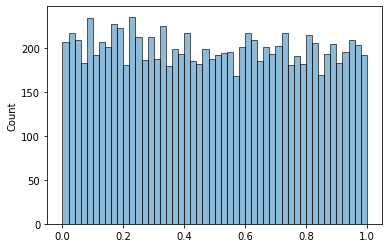

In [13]:
# Построим гистограмму с получившимися p-values
groups = sns.histplot(data = pvalue_list,
              alpha=0.5,
              kde=False,
              bins=50)

Как видно, распределение получившихся p-values близко в равномерному, т.е. присутствуют значения близкие к 0. Т.к. наш уровень значимости 0.05, в 5% случаев тест должен давать результат о различии в выборках.
Расчеты подтверждают, что ~95% сравнений подвыборок значимых различий не обнаруживается.

-------

In [15]:
# Запрос данных по экспериментальной (2) и контрольной группам (1). 
# Даты эксперимента: с 2022-04-24 по 2022-04-30
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
ab_test_df = pandahouse.read_clickhouse(q, connection=connection)

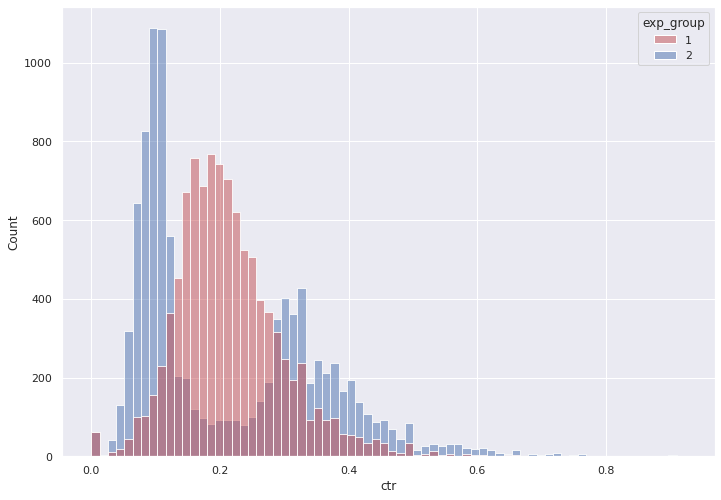

In [18]:
# Построим гистограммы и визуально сравним получившиеся ctr между двумя группами
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = ab_test_df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

В тестовой группе произошла сегментация пользователей: две группы пользователей отреагировали по разному на новую рекомендательную систему. 
Видно, что распределение имеет два пика, одна часть пользоваталей теперь с меньшей вероятностью будут кликать при просмотре, другой части пользоваталей рекомендательная система понравилась (ctr выше).

In [19]:
# Т.к. распределение далеко от нормалного, сравним результаты статистически при помощи теста Mann-Witney
print(stats.mannwhitneyu(ab_test_df[ab_test_df.exp_group == 1].ctr,
                ab_test_df[ab_test_df.exp_group == 2].ctr, 
                alternative = 'two-sided'))

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)


In [20]:
# Попробуем посчитать сглаженный CTR. Ситуацию это не исправит, но сможем быть более уверенными в том, что на данные не влияют выборосы с небольшим количеством просмотров.
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = ab_test_df[ab_test_df.exp_group == 1].likes.sum()/ab_test_df[ab_test_df.exp_group == 1].views.sum()
global_ctr_2 = ab_test_df[ab_test_df.exp_group == 2].likes.sum()/ab_test_df[ab_test_df.exp_group == 2].views.sum()

group1 = ab_test_df[ab_test_df.exp_group == 1].copy()
group2 = ab_test_df[ab_test_df.exp_group == 2].copy()

group1['smothed_ctr'] = ab_test_df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = ab_test_df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
ab_test_df_smooth = pd.concat([group1, group2]).reset_index(drop=True)

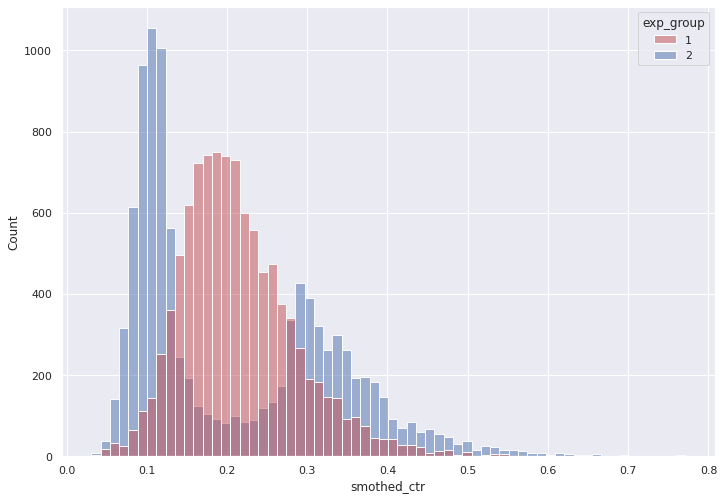

In [21]:
groups = sns.histplot(data = ab_test_df_smooth, 
              x='smothed_ctr', 
              hue = 'exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [22]:
# Доля пользователей, которым понравилась новая рекомендательная система
(ab_test_df[ab_test_df.exp_group == 2].ctr > ab_test_df[ab_test_df.exp_group == 1].ctr.mean()).sum() / len(ab_test_df[ab_test_df.exp_group == 2].ctr)

0.43508842443729906

Видно, что новая рекомендательная система действительно повлияла на поведение пользователей, однако общий уровень ctr мы значимо увеличить не смогли. 
Для части пользователей активность (ctr) возрасла, для другой - снизилась. Вероятно, в нашем сервисе есть две категории пользователей с различными поведенческими паттернами, что требует дальнейшего исследования и выявление причин получившейся сегментации.

Рекомендация: новую рекомендательную систему в текущем виде для всех пользоваталей вводить не стоит, однако можно предусмотреть возможность выбора системы пользователями в настройках сервиса. Возможно также разработать функциональность по определению пользователей, для которых новая система будет более эффективной, при помощи ML-инструментов.

---------------------------------------

In [24]:
# Попробуем новую метрику линеаризированных лайков от Яндекса
# Будем сравнивать 0 и 3, и 1 и 2. Контрольные группы в каждой паре - 0 и 1
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

40079

In [27]:
# Считаем общий CTR в контрольной группе
global_ctr_0 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

In [28]:
# Посчитаем в обеих группах поюзерную метрику
linear_likes_0 = df[df.exp_group == 0].likes - df[df.exp_group == 0].views*global_ctr_0
linear_likes_1 = df[df.exp_group == 1].likes - df[df.exp_group == 1].views*global_ctr_1
linear_likes_2 = df[df.exp_group == 2].likes - df[df.exp_group == 2].views*global_ctr_1
linear_likes_3 = df[df.exp_group == 3].likes - df[df.exp_group == 3].views*global_ctr_0

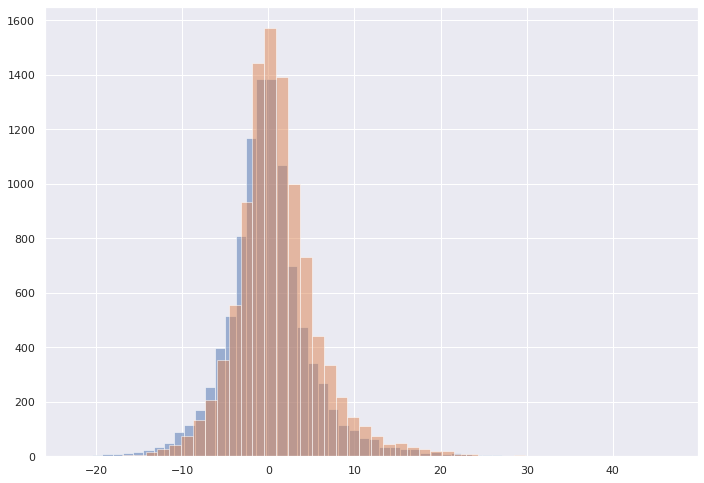

In [31]:
# Сравним распределения 0 и 3 групп
plt.hist(linear_likes_0, 
         alpha=0.5, bins=50)
plt.hist(linear_likes_3,
         alpha=0.5, bins=50)
plt.show()

Заметно смещенеие красной гистограммы (тестовая группа) вправо, т.к. по этой метрике также можем подтвердить эффективность нововведений

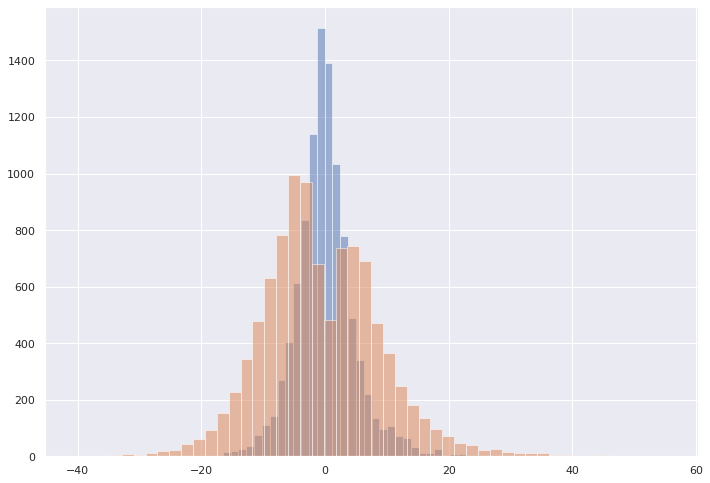

In [32]:
# Сравним распределения 1 и 2 групп
plt.hist(linear_likes_1, 
         alpha=0.5, bins=50)
plt.hist(linear_likes_2,
         alpha=0.5, bins=50)
plt.show()

Видно, что новая метрика также показывает наличие двух групп пользователей с разной реакцией на новую систему

In [37]:
# Mann-Witney для 0 и 3 групп
stats.mannwhitneyu(linear_likes_0,
                   linear_likes_3,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43338326.0, pvalue=1.1517315029786597e-63)

In [45]:
# t-test для 0 и 3 групп
stats.ttest_ind(linear_likes_0,
                linear_likes_3,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

Новая метрика подтверждает результаты A/B теста по простому CTR и в t-тесте и в тесте Манна-Уитни

In [46]:
# Mann-Witney для 1 и 2 групп
stats.mannwhitneyu(linear_likes_1,
                   linear_likes_2, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)

In [47]:
# t-test для 1 и 2 групп
stats.ttest_ind(linear_likes_1,
                linear_likes_2,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)

In [48]:
# t-test по CTR
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Для 1 и 2 групп по новой метрике видны различия в t-тесте. Ту разницу в изменении поведении пользоваталей t-тест на CTR не уловил, однако по новой метрике она видна. Тест Манна-Уитни по прежнему фиксирует различия в выборках при высоком уровне значимости.